In [149]:
from os import listdir
from xml.dom.minidom import parse
import networkx

import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))
import string

# import nltk CoreNLP module (just once)
from nltk.parse.corenlp import CoreNLPDependencyParser
# connect to your CoreNLP server (just once)
corenlp_parser = CoreNLPDependencyParser(url="http://localhost:9000")

In [148]:
!pip install networkx

     |████████████████████████████████| 1.6 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.5
    Uninstalling decorator-5.0.5:
      Successfully uninstalled decorator-5.0.5


# Data analysis
Examine (by hand or collecting simple statistics) the train
dataset and try to infer general rules that are right in most
cases, even if they seldom apply (high precision, low recall

In [150]:
def get_offsets(word, s):
    '''
    Task:
        Given a word and sentence, returns its starting end ending index in the sentence.
    
    Input:
        word: word to find offsets for
        s: sentence containing the word
    
    Output:
        Returns a tuple containing the start and end offset.
    '''
    start = s.find(word)
    end = start + len(word) - 1
    return start, end

def analyze(s):
    '''
    Task:
        Given one sentence, sends it to CoreNLP to obtain the tokens, tags,
        and dependency tree. It also adds the start/end offsets to each token.
    
    Input:
        s: string containing the text for one sentence
    
    Output:
        Returns the nltk DependencyGraph object produced by CoreNLP, enriched with token offsets.

    '''
    s = s.replace("%", "<percentage>")
    tree, = corenlp_parser.raw_parse(s)
    for n in tree.nodes.items():
        node = n[1]
        if node['word']:
            start, end = get_offsets(node['word'], s)
            node['start'] = start
            node['end'] = end
            
    return tree

In [151]:
# tree = analyze("Interaction between oxytocin and antidiuretic hormone and its effect on the milk secretion by alveoli of the mammary gland of lactating rats.")
# print(tree.nodes.items())
#s2 = "Co-administration of oral ketoconazole 200 mg twice daily increased retapamulin geometric mean AUC(0-24) and Cmax by 81% after topical application of retapamulin ointment, 1% on the abraded skin of healthy adult males."
s1 = 'Caution should be exercised when combining resorcinol or salicylic acid with DIFFERIN Gel'
tree = analyze(s1)
#print(tree.tree())
#print(tree.nodes.items())
#for n in tree.nodes.items():
#    node = n[1]
#    if node["word"] and node["word"] == 'resorcinol':
##        lemma = node['lemma']
#        address_h = node['head']
#        rel = node['rel']
#        print(rel)
##for n in tree.nodes.items():
#   node = n[1]
##    if node['address'] == address_h:
#        print(node)

***

In [152]:
datadir = "../../labAHLT/data/train"
entities = {}
pairs = []
analyses = []
sentences = []


for f in listdir(datadir):

    tree = parse(datadir + "/" + f)

    sents = tree.getElementsByTagName("sentence")
    for s in sents:

        sid = s.attributes["id"].value # get sentence id
        stext = s.attributes["text"].value # get sentence text
        
        
        if len(stext) == 0:
            continue
            
        sentences.append(s)
        
        ents = s.getElementsByTagName("entity")
        for e in ents:
            eid = e.attributes["id"].value
            entities[eid] = e.attributes["text"].value
        
        # Tokenize, tag, and parse sentence
        analysis = analyze(stext)
        analyses.append(analysis)

        # for each pair in the sentence , decide whether it is DDI and its type
        prs = s.getElementsByTagName("pair")
        temp_pairs = []
        for p in prs:
            id_e1 = p.attributes["e1"].value
            id_e2 = p.attributes["e2"].value
            interaction = p.attributes["type"].value if p.attributes["ddi"].value == "true" else None
            temp_pairs.append({"e1": id_e1, "e2": id_e2, "sid": sid, "interaction": interaction})
#             ddi_type = check_interaction(analysis, entities , id_e1 , id_e2)
#            if ddi_type != None:
#                print(sid +"|"+ id_e1 +"|"+ id_e2 +"|"+ ddi_type,file = outf)
#            if p.attributes["ddi"].value == "true":
#                print(sid +"|"+ id_e1 +"|"+ id_e2 +"|"+ interaction)
        pairs.append(temp_pairs)

In [196]:
def find_verb_where_e_is_dobj(tree, entity):
    # inside which verb's direct objects is entity?
    for n in tree.nodes.items():
        node = n[1]

        if entity is not None and len(node['deps']['obj']) > 0  and node['deps']['obj'][0] == entity['address']:
            return node

def find_verb_where_e_is_subj(tree, entity):
    for n in tree.nodes.items():
        node = n[1]
        if entity is not None and len(node['deps']['nsubj']) > 0 and node['deps']['nsubj'][0] == entity['address']:
            return node


In [207]:
def find_entity_in_tree(entity, tree):
    for n in tree.nodes.items():
        node = n[1]
        if node["word"] and entity.find(node["word"]) >= 0:
            return node
    return None

def analyze_interactions_train(analysis, entities, e1, e2):
    tree = analysis.tree()
    nxgraph = analysis.nx_graph().to_undirected()
    entity1 = entities[e1]
    entity2 = entities[e2]
        

    
#     print(entity1)
#     print(entity2)
    
    e1_node = find_entity_in_tree(entity1, analysis)
    e2_node = find_entity_in_tree(entity2, analysis)
#     print(e1_node)
    
    shortest_path = networkx.shortest_path(nxgraph, e1_node['address'], e2_node['address']) if (e1_node and e2_node) else []
    shortest_path = [analysis.nodes[x]['lemma'] for x in shortest_path]
           
    e1_tag = e1_node['tag'] if e1_node else None
    e2_tag = e2_node['tag'] if e2_node else None

    e1_addr =  e1_node['address'] if e1_node else 0
    e2_addr = e2_node['address'] if e2_node else 0  
    
    # HEAD ANALYSIS
    h_e1 = e1_node['head'] if e1_node else None      #position of the head
    head_e1 = analysis.nodes[h_e1]['lemma'] if e1_node else None
    tag_head_e1 = analysis.nodes[h_e1]['tag'] if e1_node else None
    
    h_e2 = e2_node['head'] if e2_node else None      #position of the head
    head_e2 = analysis.nodes[h_e2]['lemma'] if e2_node else None
    tag_head_e2 = analysis.nodes[h_e2]['tag'] if e2_node else None
    
    t_h1_l = tag_head_e1[0].lower if e1_node else None
    t_h2_l = tag_head_e2[0].lower if e2_node else None
    
    rel_e1_h1 = e1_node['rel'] if e1_node else None
    rel_e2_h2 = e2_node['rel'] if e2_node else None
    
    # subject-object
    verb_obj_e1 = find_verb_where_e_is_dobj(analysis, e1_node)
    verb_obj_e2 = find_verb_where_e_is_dobj(analysis, e2_node)
    
    verb_subj_e1 = find_verb_where_e_is_subj(analysis, e1_node)
    verb_subj_e2 = find_verb_where_e_is_subj(analysis, e2_node)
    
    verb_obj_e1 = verb_obj_e1['lemma'] if verb_obj_e1 else None
    verb_obj_e2 = verb_obj_e2['lemma'] if verb_obj_e2 else None
    verb_subj_e1 = verb_subj_e1['lemma'] if verb_subj_e1 else None
    verb_subj_e2 = verb_subj_e2['lemma'] if verb_subj_e2 else None
    
    if head_e1 == head_e2 and t_h1_l == 'v' and t_h2_l == 'v':
        under_same_verb = True
    else:
        under_same_verb = False
        
    if head_e1 == head_e2 and head_e1 != None and head_e2 != None:
        under_same_word = True
    else:
        under_same_word = False
    
    if head_e1 == entity2 and head_e1 != None:
        e1_under_e2 = True
    else: 
        e1_under_e2 = False
    
    if head_e2 == entity1 and head_e2 != None:
        e2_under_e1 = True
    else:
        e2_under_e1 = False


    return  e1_tag, e2_tag, e2_addr - e1_addr, head_e1, head_e2, tag_head_e1, tag_head_e2, rel_e1_h1, rel_e2_h2, under_same_verb, under_same_word, e1_under_e2, e2_under_e1, verb_obj_e1, verb_obj_e2, verb_subj_e1, verb_subj_e2, shortest_path

In [208]:
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        e1_tag, e2_tag, address_difference, e1_h, e2_h, h1_t, h2_t, rel1, rel2, u_s_v, u_s_w, e1_e2, e2_e1, verb_obj_e1, verb_obj_e2, verb_subj_e1, verb_subj_e2, shortest_path = analyze_interactions_train(analysis, entities, pair['e1'], pair['e2'])
        pair['e1_tag'] = e1_tag
        pair['e2_tag'] = e2_tag
        pair['address_difference'] = address_difference
        pair['head_e1'] = e1_h
        pair['head_e2'] = e2_h
        pair['h1_tag'] = h1_t
        pair['h2_tag'] = h2_t
        pair['rel_e1_h1'] = rel1
        pair['rel_e2_h2'] = rel2
        pair['under_same_verb'] = u_s_v
        pair['under_same_word'] = u_s_w
        pair['e1_under_e2'] = e1_e2
        pair['e2_under_e1'] = e2_e1
        pair['verb_obj_e1'] = verb_obj_e1
        pair['verb_obj_e2'] = verb_obj_e2
        pair['verb_subj_e1'] = verb_subj_e1
        pair['verb_subj_e2'] = verb_subj_e2
        pair['shortest_path'] = shortest_path
        
temp_pairs = [item for sublist in pairs for item in sublist]
df = pd.DataFrame(temp_pairs)
df.head(20)

,e1,e2,sid,interaction,e1_tag,e2_tag,address_difference,head_e1,head_e2,h1_tag,...,rel_e2_h2,under_same_verb,under_same_word,e1_under_e2,e2_under_e1,verb_obj_e1,verb_obj_e2,verb_subj_e1,verb_subj_e2,shortest_path
0,DDI-DrugBank.d59.s0.e0,DDI-DrugBank.d59.s0.e1,DDI-DrugBank.d59.s0,mechanism,NNP,NN,5,effect,potentiate,NNS,...,obl,False,False,False,False,None,None,None,None,"[ERGOMAR, effect, potentiate, triacetyloleando..."
1,DDI-DrugBank.d59.s0.e0,DDI-DrugBank.d59.s0.e2,DDI-DrugBank.d59.s0,None,NNP,NN,11,effect,metabolism,NNS,...,nmod,False,False,False,False,None,None,None,None,"[ERGOMAR, effect, potentiate, inhibit, metabol..."
2,DDI-DrugBank.d59.s0.e1,DDI-DrugBank.d59.s0.e2,DDI-DrugBank.d59.s0,mechanism,NN,NN,6,potentiate,metabolism,VBN,...,nmod,False,False,False,False,None,None,None,None,"[triacetyloleandomycin, potentiate, inhibit, m..."
3,DDI-DrugBank.d59.s1.e0,DDI-DrugBank.d59.s1.e1,DDI-DrugBank.d59.s1,effect,NNP,NNS,4,effect,ERGOMAR,NNS,...,conj,False,False,False,True,None,None,None,None,"[ERGOMAR, drug]"
4,DDI-DrugBank.d335.s1.e0,DDI-DrugBank.d335.s1.e1,DDI-DrugBank.d335.s1,effect,NN,JJ,7,dipotassium,increase,NN,...,nsubj,False,False,False,False,None,None,None,increase,"[clorazepate, dipotassium, prolong, increase, ..."
5,DDI-DrugBank.d335.s1.e0,DDI-DrugBank.d335.s1.e2,DDI-DrugBank.d335.s1,effect,NN,NN,11,dipotassium,hexobarbital,NN,...,conj,False,False,False,False,None,None,None,None,"[clorazepate, dipotassium, prolong, increase, ..."
6,DDI-DrugBank.d335.s1.e0,DDI-DrugBank.d335.s1.e3,DDI-DrugBank.d335.s1,effect,NN,CC,8,dipotassium,alcohol,NN,...,cc,False,False,False,False,None,None,None,None,"[clorazepate, dipotassium, prolong, increase, ..."
7,DDI-DrugBank.d335.s1.e1,DDI-DrugBank.d335.s1.e2,DDI-DrugBank.d335.s1,None,JJ,NN,4,increase,hexobarbital,VBZ,...,conj,False,False,False,True,None,None,increase,None,"[hexobarbital, alcohol]"
8,DDI-DrugBank.d335.s1.e1,DDI-DrugBank.d335.s1.e3,DDI-DrugBank.d335.s1,None,JJ,CC,1,increase,alcohol,VBZ,...,cc,False,False,False,False,None,None,increase,None,"[hexobarbital, alcohol, or]"
9,DDI-DrugBank.d335.s1.e2,DDI-DrugBank.d335.s1.e3,DDI-DrugBank.d335.s1,None,NN,CC,-3,hexobarbital,alcohol,JJ,...,cc,False,False,False,False,None,None,None,None,"[alcohol, or]"


***

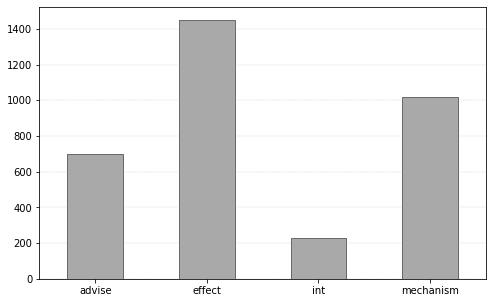

In [113]:
#df['interaction'].unique()
df_advise = df.loc[df['interaction']=='advise']
df_effect = df.loc[df['interaction']=='effect']
df_int = df.loc[df['interaction']=='int']
df_mechanism = df.loc[df['interaction']=='mechanism']

advise_count = df_advise.shape[0]
effect_count = df_effect.shape[0]
int_count = df_int.shape[0]
mechanism_count = df_mechanism.shape[0]

interaction_counts = pd.DataFrame(df.groupby('interaction').count()['e1'])
ax = interaction_counts.plot.bar(figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

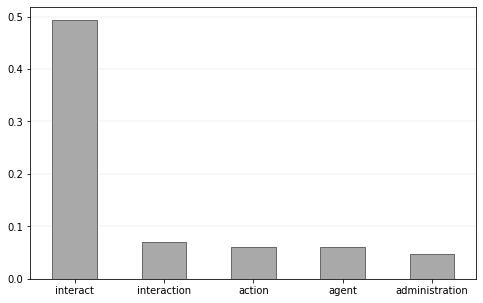

In [114]:
words = df_int['head_e1'].value_counts()/int_count
ax = words[:5].plot.bar(figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)
#plt.savefig('int_e1_h.png', bbox_inches = 'tight', pad_inches = 0.05)

In [115]:
# Count occurences head_e1-head_e2 together
comb_mech = df_mechanism[['head_e1', 'head_e2']].value_counts()
comb_mech[comb_mech > 10]

#df_effect.groupby(['head_e1','head_e2']).size()

head_e1        head_e2      
presence       Acetaminophen    22
concentration  intake           20
level          Acetazolamide    19
dose           dose             16
presence       presence         15
use            eg               11
dtype: int64

***
### Entity Tag Analysis

In [116]:
#df_mechanism['h1_tag'].value_counts() / mechanism_count
#df_effect['h1_tag'].value_counts() / effect_count
#df_advise['h1_tag'].value_counts() / advise_count
#df_int['h1_tag'].value_counts() / int_count

#comb_advise = df_advise[['e2_tag', 'h2_tag']].value_counts() / advise_count
#comb_advise[:10]

comb_mechanism = df_mechanism[['e1_tag', 'h1_tag']].value_counts() / mechanism_count
comb_mechanism[:10]

#comb_effect = df_effect[['e1_tag', 'h1_tag']].value_counts() / effect_count
#comb_effect[:10]

#comb_int = df_int[['e1_tag', 'h1_tag']].value_counts() / int_count
#comb_int[:10]

e1_tag  h1_tag
NN      NN        0.255882
        NNS       0.100000
NNP     NN        0.073529
        NNS       0.053922
NN      VBN       0.045098
DT      NN        0.037255
NNS     NN        0.033333
NNP     VBZ       0.033333
IN      NNS       0.029412
NNP     VBN       0.028431
dtype: float64

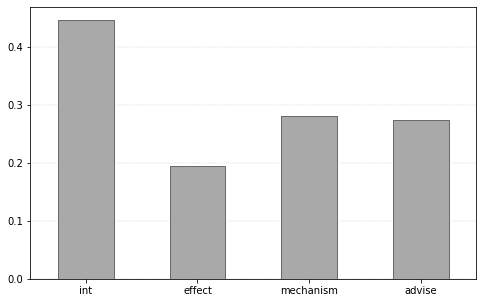

In [117]:
# e1 is an NNP
df1 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='NNP'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='NNP'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='NNP'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='NNP'].count()[0]/advise_count]})

ax = df1.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

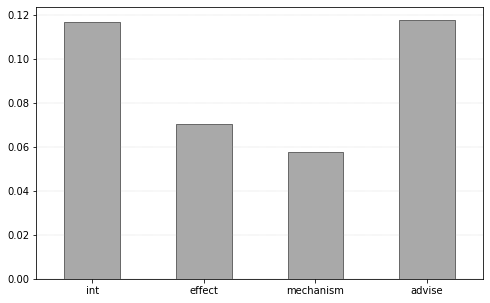

In [118]:
# e2 is an NNP
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e2_tag']=='NNP'].count()[0]/int_count,
                                                                            df_effect.loc[df['e2_tag']=='NNP'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e2_tag']=='NNP'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e2_tag']=='NNP'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

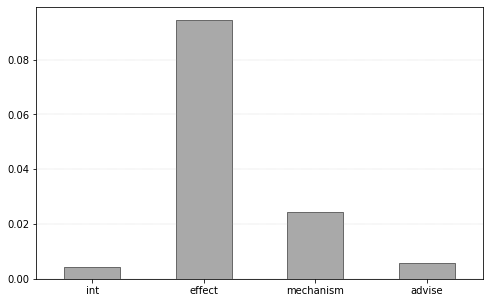

In [119]:
# e1 is a JJ
df2 = pd.DataFrame({'lab' : ['int', 'effect', 'mechanism', 'advise'], 'Count' : [df_int.loc[df['e1_tag']=='JJ'].count()[0]/int_count,
                                                                            df_effect.loc[df['e1_tag']=='JJ'].count()[0]/effect_count,
                                                                            df_mechanism.loc[df['e1_tag']=='JJ'].count()[0]/mechanism_count,
                                                                            df_advise.loc[df['e1_tag']=='JJ'].count()[0]/advise_count]})

ax = df2.plot.bar(x='lab', y = 'Count', figsize = (8,5), rot=0, legend = False, color='darkgrey', edgecolor='dimgray')
ax.set_xlabel("")
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

### Relationship Analysis
### Path Analysis

***
### Sentence Analysis

Instructor's example: 
- Pairs with an interaction of type _<font color=blue>effect</font>_ often have clue words like <font color=blue>administer, potentiate, prevent, </font> etc. between e1 and e2
- Pairs with ann interaction of type _<font color=blue>mechanism</font>_ often have clue words like _<font color=blue>reduce, increase, decrease,</font>_ etc. between e1 and e2. 
- Pairs with ann interaction of type _<font color=blue>int</font>_ often have clue words like _<font color=blue>interact, interaction,</font>_ etc. between e1 and e2. 
- Better results may be achieved if properties of the dependency tree are used (e.g. e1 is _<font color=red>under</font>_ e2, both e1 and e2 are _<font color=red>under</font>_ the same verb, e1 is _<font color=red>under</font>_ the subject of certain verbs (*enhance*, *reduce*, ...), etc.)

In [120]:
# Get Words between entities e1 and e2 in sentence
# Get Words outside subsentence delimited by e1-e2
dict_sentences = {}
lst = []
for s in sentences:
    sid = s.attributes["id"].value
    stext = s.attributes["text"].value
    dict_sentences[sid] = stext
# print(dict_sentences)

In [121]:
def get_positions(analysis, entities, e1, e2):
    tree = analysis.tree()
    
    entity1 = entities[e1]
    entity2 = entities[e2]
    
    e1_node = find_entity_in_tree(entity1, analysis)
    e2_node = find_entity_in_tree(entity2, analysis)
           
    e1_start =  e1_node['start'] if e1_node else 0
    e1_end = e1_node['end'] if e1_node else 0  
    
    e2_start =  e2_node['start'] if e2_node else 0
    e2_end = e2_node['end'] if e2_node else 0  


    return e1_start, e1_end, e2_start, e2_end

def dict_add_one(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1

In [122]:
word_dict = {'effect': 
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{},
                     'num_interactions': 0
                    },
                 'mechanism':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{},
                     'num_interactions': 0
                    },
                 'int':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{},
                     'num_interactions': 0
                    },
                 'advise':
                    {'clue_words':{},
                     'outside_words':{},
                     'sentence_words':{},
                     'num_interactions': 0
                    },
                }
import nltk
verb_tags = ['VB', 'VBD', 'VBG','VBN', 'VBP', 'VBZ', 'MD', 'RB', 'RBR', 'RBS', 'WRB'] #verbs and adverbs
def get_verb_tokens(sentence_text):
    #filters tokens by verb
    tokens = word_tokenize(sentence_text)
    return [word for word, tag in nltk.pos_tag(tokens) if tag in verb_tags]

# Code should need improvement, there are pairs that throw error 
# Filtering words by verb should be better
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        start_e1, end_e1, start_e2, end_e2 = get_positions(analysis, entities, pair['e1'], pair['e2'])
        sid = pair['sid']
        interaction = pair['interaction']
        sentence = dict_sentences[sid]
    
        if interaction in ['effect', 'mechanism','int','advise']:
            dict_add_one(word_dict[interaction], 'num_interactions')
            between_entities = [word for word in get_verb_tokens(sentence[end_e1+1:start_e2]) if word not in stopwords and word not in string.punctuation]
            for word in between_entities:
                dict_add_one(word_dict[interaction]['clue_words'], word) 


            not_between = [word for word in get_verb_tokens(sentence[:start_e1] + ' ' + sentence[end_e2+1:]) if word not in stopwords and word not in string.punctuation]
            for word in not_between:
                dict_add_one(word_dict[interaction]['outside_words'], word) 

            full_sentence = [word for word in word_tokenize(sentence[::1]) if word not in stopwords and word not in string.punctuation]
            for word in full_sentence:
                dict_add_one(word_dict[interaction]['sentence_words'], word) 
    
    #break

suggested rules:

    if 'enhance', 'administered', 'cause', 'affecting' between e1 and e2, then 'effect'
    
    if 'decreased', 'reported', 'ethosuximide', 'siginicantly', 'interfere', 'inhibit' between e1 and e2, then 'mechanism'
    
    if 'interact', 'following', 'lower' between e1 and e2 then 'int'
    
    if 'administered', 'concomitantly', 'metabolized', 'coadministered', 'recommended then 'advise'
    
   We could also try stemming the words i guess

In [123]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print("Interaction: ", i)
    print("---Clue_words---")
    print(sorted(word_dict[i]['clue_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---Outside e1-e2 interval---")
    print(sorted(word_dict[i]['outside_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n --Words in sentence--")
    print(sorted(word_dict[i]['sentence_words'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------------------------------------------------------\n')

Interaction:  effect
---Clue_words---
[('may', 323), ('include', 90), ('including', 72), ('enhance', 66), ('concomitantly', 66), ('administered', 65), ('reduce', 49), ('increased', 46), ('potentiated', 45), ('increase', 41), ('reported', 35), ('decrease', 23), ('potentiate', 23), ('decreased', 23), ('given', 20), ('used', 20), ('affecting', 20), ('taking', 19), ('cause', 19), ('enhanced', 19)]

 ---Outside e1-e2 interval---
[('may', 431), ('reported', 128), ('receiving', 115), ('increase', 108), ('blocking', 96), ('including', 94), ('increased', 84), ('result', 75), ('associated', 57), ('salicylates', 55), ('reportedly', 55), ('cause', 54), ('prolonged', 53), ('enhance', 51), ('acting', 50), ('long', 50), ('administered', 47), ('concomitantly', 47), ('used', 43), ('nondepolarizing', 42)]

 --Words in sentence--
[('may', 749), ('drugs', 535), ('effects', 362), ('agents', 325), ('acid', 303), ('alcohol', 272), ('inhibitors', 260), ('The', 245), ('patients', 220), ('oral', 194), ('sodium'

In [124]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print(word_dict[i]['num_interactions'])
    word_dict[i]['clue_words'] = [(word, c/word_dict[i]['num_interactions']) for word, c in word_dict[i]['clue_words'].items()]
    word_dict[i]['outside_words']= [(word, c/word_dict[i]['num_interactions']) for word, c in word_dict[i]['outside_words'].items()]
    word_dict[i]['sentence_words'] = [(word, c/word_dict[i]['num_interactions']) for word, c in word_dict[i]['sentence_words'].items()]

    print("Interaction: ", i)
    print("---Clue_words---")
    print(sorted(word_dict[i]['clue_words'], key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---Outside e1-e2 interval---")
    print(sorted(word_dict[i]['outside_words'], key=lambda item: item[1], reverse=True)[0:20])
    print("\n --Words in sentence--")
    print(sorted(word_dict[i]['sentence_words'], key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------------------------------------------------------\n')
    


1450
Interaction:  effect
---Clue_words---
[('may', 0.22275862068965518), ('include', 0.06206896551724138), ('including', 0.0496551724137931), ('enhance', 0.04551724137931035), ('concomitantly', 0.04551724137931035), ('administered', 0.04482758620689655), ('reduce', 0.03379310344827586), ('increased', 0.031724137931034485), ('potentiated', 0.03103448275862069), ('increase', 0.028275862068965516), ('reported', 0.02413793103448276), ('decrease', 0.015862068965517243), ('potentiate', 0.015862068965517243), ('decreased', 0.015862068965517243), ('given', 0.013793103448275862), ('used', 0.013793103448275862), ('affecting', 0.013793103448275862), ('taking', 0.01310344827586207), ('cause', 0.01310344827586207), ('enhanced', 0.01310344827586207)]

 ---Outside e1-e2 interval---
[('may', 0.29724137931034483), ('reported', 0.08827586206896551), ('receiving', 0.07931034482758621), ('increase', 0.07448275862068965), ('blocking', 0.06620689655172414), ('including', 0.06482758620689655), ('increased',

# position in tree

In [125]:
positions_word_dict = {'effect': 
                    {'e1_under_e2':0,
                     'e2_under_e1':0,
                     'under_same_word':0,
                     'under_same_verb': 0,
                     'num_interactions': 0
                    },
                 'mechanism':
                    {'e1_under_e2':0,
                     'e2_under_e1':0,
                     'under_same_word':0,
                     'under_same_verb': 0,
                     'num_interactions': 0
                    },
                 'int':
                    {'e1_under_e2':0,
                     'e2_under_e1':0,
                     'under_same_word':0,
                     'under_same_verb': 0,
                     'num_interactions': 0
                    },
                 'advise':
                    {'e1_under_e2':0,
                     'e2_under_e1':0,
                     'under_same_word':0,
                     'under_same_verb': 0,
                     'num_interactions': 0
                    },
                }

for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        interaction = pair['interaction']      
    
        if interaction in ['effect', 'mechanism','int','advise']:
            dict_add_one(positions_word_dict[interaction], 'num_interactions')
            if pair['e1_under_e2']:
                dict_add_one(positions_word_dict[interaction], 'e1_under_e2')
            if pair['e2_under_e1']:
                dict_add_one(positions_word_dict[interaction], 'e2_under_e1')  
            if pair['under_same_word']:
                dict_add_one(positions_word_dict[interaction], 'under_same_word')  
            if pair['under_same_verb']:
                dict_add_one(positions_word_dict[interaction], 'under_same_verb')  
            
        
    
    #break

In [126]:
for i in ['effect', 'mechanism','int','advise']:
    print("Interaction: ", i)
    for key, value in positions_word_dict[i].items():
        if key != 'num_interactions':
            print(f'{key}\t{value}\t{value/positions_word_dict[i]["num_interactions"]}')
    print('--------------------------\n')

Interaction:  effect
e1_under_e2	5	0.0034482758620689655
e2_under_e1	72	0.0496551724137931
under_same_word	123	0.08482758620689655
under_same_verb	0	0.0
--------------------------

Interaction:  mechanism
e1_under_e2	1	0.000980392156862745
e2_under_e1	36	0.03529411764705882
under_same_word	139	0.13627450980392156
under_same_verb	0	0.0
--------------------------

Interaction:  int
e1_under_e2	0	0.0
e2_under_e1	12	0.05194805194805195
under_same_word	28	0.12121212121212122
under_same_verb	0	0.0
--------------------------

Interaction:  advise
e1_under_e2	3	0.00430416068866571
e2_under_e1	54	0.07747489239598278
under_same_word	89	0.12769010043041606
under_same_verb	0	0.0
--------------------------



suggested rules:

if under_same_word then mechanism or int?

if e1 under e2 then effect?

In [127]:
word_dict = {'effect': 
                    {'head_e1':{},
                     'head_e2':{},
                     'heads_e1_e2': {},
                     'num_interactions': 0
                    },
                 'mechanism':
                    {'head_e1':{},
                     'head_e2':{},
                     'heads_e1_e2': {},
                     'num_interactions': 0
                    },
                 'int':
                    {'head_e1':{},
                     'head_e2':{},
                     'heads_e1_e2': {},
                     'num_interactions': 0
                    },
                 'advise':
                    {'head_e1':{},
                     'head_e2':{},
                     'heads_e1_e2': {},
                     'num_interactions': 0
                    },
                }
import nltk
# verb_tags = ['VB', 'VBD', 'VBG','VBN', 'VBP', 'VBZ', 'MD', 'RB', 'RBR', 'RBS', 'WRB'] #verbs and adverbs
def get_verb_tokens(sentence_text):
    #filters tokens by verb
    tokens = word_tokenize(sentence_text)
    return [word for word, tag in nltk.pos_tag(tokens) if tag in verb_tags]

    

# Code should need improvement, there are pairs that throw error 
# Filtering words by verb should be better
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        start_e1, end_e1, start_e2, end_e2 = get_positions(analysis, entities, pair['e1'], pair['e2'])
        sid = pair['sid']
        interaction = pair['interaction']
        sentence = dict_sentences[sid]
    
        if interaction in ['effect', 'mechanism','int','advise']:
            dict_add_one(word_dict[interaction], 'num_interactions')
            dict_add_one(word_dict[interaction]['head_e1'], pair['head_e1'])
            dict_add_one(word_dict[interaction]['head_e2'], pair['head_e2'])
            dict_add_one(word_dict[interaction]['heads_e1_e2'], (pair['head_e1'], pair['head_e2']))
    
    #break

In [128]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print("Interaction: ", i)
    print("---head e1---")
    print(sorted(word_dict[i]['head_e1'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---head e2 ---")
    print(sorted(word_dict[i]['head_e2'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---both heads ---")
    print(sorted(word_dict[i]['heads_e1_e2'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------------------------------------------------------\n')

Interaction:  effect
---head e1---
[('use', 110), ('response', 83), ('effect', 80), ('action', 65), ('administration', 60), ('agent', 46), ('enhance', 41), ('patient', 38), ('inhibitor', 30), (None, 23), ('increase', 23), ('decrease', 21), ('receive', 21), ('drug', 20), ('injection', 17), ('reduce', 17), ('report', 15), ('administer', 15), ('hydrochloride', 14), ('study', 14)]

 ---head e2 ---
[('effect', 150), ('alcohol', 61), ('patient', 51), ('action', 30), ('use', 30), ('man', 28), ('drug', 25), ('combination', 25), ('inhibitor', 24), ('g.', 24), ('agent', 23), ('activity', 21), ('analgesic', 20), ('potentiate', 19), ('antibiotic', 17), ('antidepressant', 16), ('hypnotic', 16), ('induce', 15), ('administration', 15), ('steroid', 15)]

 ---both heads ---
[(('response', 'man'), 28), (('response', 'alcohol'), 28), (('agent', 'g.'), 16), (('use', 'use'), 15), (('response', 'steroid'), 15), (('enhance', 'effect'), 14), (('patient', 'patient'), 12), (('impair', 'anticoagulant'), 10), (('

### Suggested rules:

if (head_e1 == 'response' and head_e2 in ('man', 'alcohol', 'steroid)) then effect

id head_e1 == 'administer' and head_e2 == administer then advise

if head_e1 is None, then 'effect' or 'mechanism'?

if head_e1 in 'response', 'effect', 'enhance', then 'effect'

if head_e1 in 'concentration', 'presence', 'dose', 'absorption', 'interfere' then 'mechanism'

if head_e1 in 'interact', 'interaction', 'action', 'agent', then 'int'
    
if head_e1 in co-administration, take, 'coadminister', 'treatment', 'tell', 'therapy' then advise

if head_e2 in 'effect',  'alcohol', 'action', 'use', 'combination', 'inhibitor' then 'effect'

if head_e2 in 'metabolism', 'concentration', 'clearance;, 'level', 'absorption', 'dose', then 'mechanism'

if head_e2 in 'interact', 'interaction', then 'int'

if head_e2 in 'administer' then advise

In [132]:
word_dict = {'effect': 
                    {'verb_obj_e1':{},
                     'verb_obj_e2':{},
                     'verb_subj_e1': {},
                     'verb_subj_e2': {},
                     'obj_e1_subj_e2': {},
                     'obj_e2_subj_e1': {},
                     'num_interactions': 0
                    },
                 'mechanism':
                    {'verb_obj_e1':{},
                     'verb_obj_e2':{},
                     'verb_subj_e1': {},
                     'verb_subj_e2': {},
                                          'obj_e1_subj_e2': {},
                     'obj_e2_subj_e1': {},
                     'num_interactions': 0
                    },
                 'int':
                    {'verb_obj_e1':{},
                     'verb_obj_e2':{},
                     'verb_subj_e1': {},
                     'verb_subj_e2': {},
                                          'obj_e1_subj_e2': {},
                     'obj_e2_subj_e1': {},
                     'num_interactions': 0
                    },
                 'advise':
                    {'verb_obj_e1':{},
                     'verb_obj_e2':{},
                     'verb_subj_e1': {},
                     'verb_subj_e2': {},
                                          'obj_e1_subj_e2': {},
                     'obj_e2_subj_e1': {},
                     'num_interactions': 0
                    },
                }
    

# Code should need improvement, there are pairs that throw error 
# Filtering words by verb should be better
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        start_e1, end_e1, start_e2, end_e2 = get_positions(analysis, entities, pair['e1'], pair['e2'])
        sid = pair['sid']
        interaction = pair['interaction']
        sentence = dict_sentences[sid]
        
    
        if interaction in ['effect', 'mechanism','int','advise']:
            dict_add_one(word_dict[interaction], 'num_interactions')
            dict_add_one(word_dict[interaction]['verb_obj_e1'], pair['verb_obj_e1'] )
            dict_add_one(word_dict[interaction]['verb_obj_e2'], pair['verb_obj_e2'] )
            dict_add_one(word_dict[interaction]['verb_subj_e1'], pair['verb_subj_e1'] )
            dict_add_one(word_dict[interaction]['verb_subj_e2'], pair['verb_subj_e2'] )
            dict_add_one(word_dict[interaction]['obj_e1_subj_e2'], (pair['verb_obj_e1'], pair['verb_subj_e2']))
            dict_add_one(word_dict[interaction]['obj_e2_subj_e1'], (pair['verb_obj_e2'], pair['verb_subj_e1']))
            
    
    #break

In [134]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print("Interaction: ", i)
    print("---verb_obj_e1---")
    print(sorted(word_dict[i]['verb_obj_e1'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---head verb_obj_e2 ---")
    print(sorted(word_dict[i]['verb_obj_e2'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---verb_subj_e1 ---")
    print(sorted(word_dict[i]['verb_subj_e1'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---verb_subj_e2 ---")
    print(sorted(word_dict[i]['verb_subj_e2'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---obj e1 subj e2 ---")
    print(sorted(word_dict[i]['obj_e1_subj_e2'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("\n ---obj e2 subj e1 ---")
    print(sorted(word_dict[i]['obj_e2_subj_e1'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------------------------------------------------------\n')

Interaction:  effect
---verb_obj_e1---
[(None, 1413), ('receive', 15), ('contain', 10), ('take', 5), ('discontinue', 3), ('concern', 1), ('add', 1), ('allow', 1), ('use', 1)]

 ---head verb_obj_e2 ---
[(None, 1421), ('receive', 6), ('take', 5), ('reduce', 5), ('include', 4), ('potentiate', 3), ('inhibit', 2), ('cause', 1), ('administer', 1), ('initiate', 1), ('discontinue', 1)]

 ---verb_subj_e1 ---
[(None, 1220), ('enhance', 41), ('increase', 22), ('decrease', 21), ('reduce', 16), ('have', 11), ('inhibit', 9), ('produce', 9), ('interact', 8), ('affect', 8), ('diminish', 7), ('potentiate', 7), ('antagonize', 7), ('use', 6), ('capable', 5), ('augment', 5), ('cause', 5), ('interfere', 4), ('counteract', 4), ('prevent', 3)]

 ---verb_subj_e2 ---
[(None, 1427), ('exhibit', 5), ('potentiate', 5), ('reduce', 4), ('increase', 2), ('result', 2), ('fail', 1), ('worsen', 1), ('produce', 1), ('affect', 1), ('effective', 1)]

 ---obj e1 subj e2 ---
[((None, None), 1391), (('receive', None), 14), (

# with shortest path

In [227]:
word_dict = {'effect': 
                    {'shortest_path':{},
                     'words_in_shortest_path': {},
                     'num_interactions': 0
                    },
                 'mechanism':
                    {'shortest_path':{},
'words_in_shortest_path': {},
                     'num_interactions': 0
                    },
                 'int':
                    {'shortest_path':{},
'words_in_shortest_path': {},
                     'heads_e1_e2': {},
                     'num_interactions': 0
                    },
                 'advise':
                    {'shortest_path':{},
                     'heads_e1_e2': {},'words_in_shortest_path': {},
                     'num_interactions': 0
                    },
                }
import nltk
   

# Code should need improvement, there are pairs that throw error 
# Filtering words by verb should be better
for i, pair_list in enumerate(pairs):
    analysis = analyses[i]
    for pair in pair_list:
        start_e1, end_e1, start_e2, end_e2 = get_positions(analysis, entities, pair['e1'], pair['e2'])
        sid = pair['sid']
        interaction = pair['interaction']
        sentence = dict_sentences[sid]
    
        if interaction in ['effect', 'mechanism','int','advise']:
            dict_add_one(word_dict[interaction], 'num_interactions')
#             dict_add_one(word_dict[interaction]['shortest_path'], frozenset(pair['shortest_path']))
            path_no_stopwords = [w for w in pair['shortest_path']  if w not in stopwords]
            dict_add_one(word_dict[interaction]['shortest_path'], frozenset(path_no_stopwords))
            for word in path_no_stopwords:
                dict_add_one(word_dict[interaction]['words_in_shortest_path'], word)
                
    
    #break

In [229]:
for i in ['effect', 'mechanism', 'int', 'advise']:
    print("Interaction: ", i)
    print("---shortest_path---")
    print(sorted(word_dict[i]['shortest_path'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print("---words in shortest_path---")
    print(sorted(word_dict[i]['words_in_shortest_path'].items(), key=lambda item: item[1], reverse=True)[0:20])
    print('---------------------------------------------')

Interaction:  effect
---shortest_path---
[(frozenset(), 22), (frozenset({'man', 'increase', 'response', 'anticoagulant'}), 19), (frozenset({'include', 'response', 'decrease', 'anticoagulant', 'man', 'diminish'}), 9), (frozenset({'combination', 'inhibitor', 'patient', 'hydrochloride', 'receive'}), 6), (frozenset({'combination', 'inhibitor', 'patient', 'hydrochloride', 'maoi', 'receive'}), 6), (frozenset({'hydrochloride', 'combination'}), 6), (frozenset({'use', 'patient', 'tablet', 'sumatriptan'}), 5), (frozenset({'prolong', 'inhibitor', 'MAO', 'effect', 'antihistamine'}), 4), (frozenset({'contain', 'regimen', 'proleukin', 'patient', 'receive'}), 4), (frozenset({'agent'}), 4), (frozenset({'class'}), 3), (frozenset({'drug'}), 3), (frozenset({'change', 'diuretic', 'administration', 'worsen', 'result'}), 3), (frozenset({'INDOCIN', 'reduce', 'diuretic', 'administration'}), 3), (frozenset({'response', 'alcohol', 'increase', 'anticoagulant', 'acid'}), 3), (frozenset({'experience', 'individual'

# trying things